In [4]:
%load_ext autoreload
%autoreload 2

import torch
from timeit import default_timer
device = torch.device("cpu")
import torch.nn as nn
import numpy as np
import imageio
import matplotlib.pyplot as plt
from src.preprocessing import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_path = "./data/"
radar_data = np.load(f'{data_path}/radars_2020-11-01_2022-12-31.npy')

actual_mask = radar_data > (abs(np.min(radar_data,axis=(1,2))).reshape(-1,1,1))
radar_data *= actual_mask
radar_data = min_max_scaller(radar_data)

glorys     = np.load(f'{data_path}/glorys_2020-11-01_2022-12-31.npy')
gfs = np.load(f'{data_path}/gfs_2020-11-01_2022-12-31.npy')
mask = load_mask(data_path+'mask.png')

idxs = get_clear_data_idxs(radar_data, zero_th_percent = 100, mask = mask)
pairs = get_idxs_pairs(idxs)

train_pairs = np.array(pairs[:int(len(pairs) * 0.7)])
valid_pairs = np.array(pairs[int(len(pairs) * 0.7):int(len(pairs) * 0.9)])
test_pairs = np.array(pairs[int(len(pairs) * 0.9):])

print('radar data : ', radar_data.shape)
print('glorys data :', glorys.shape)
print('gfs data :', gfs.shape)
print('train_pairs : ',  train_pairs.shape)
print('test_pairs :', test_pairs.shape)
print('valid_pairs :', valid_pairs.shape)

radar data :  (791, 825, 200)
glorys data : (791, 3, 825, 200)
gfs data : (791, 3, 825, 200)
train_pairs :  (127, 2)
test_pairs : (19, 2)
valid_pairs : (36, 2)


In [ ]:
i = 10
plt.subplot(1,2,1)
plt.imshow(radar_data[i])
plt.subplot(1,2,2)
plt.imshow(actual_mask[i])


In [231]:
# def generate_diff_data(radar_data, mask):
#     zeros_in_mask = np.logical_and(mask, np.logical_not(radar_data))                    # zeros-mask inside river 

#     zero_percentage = np.sum(zeros_in_mask.astype(int), (1,2)) * 100 / MASK_SUM         # zeros ratio inside river
#     filled_images_idxs = np.where(zero_percentage < 0.1)                                # idxs of fully filled images inside river

#     dataset = []                                                                        # var where we store final data

#     for fill_idx in filled_images_idxs[0]:                                              # go through all filled images
#         output_image = torch.tensor([])                                                 # difference masks with unique data 
#         input_radar = torch.tensor([])
#         used_idxs = []                                                                  # idxs of radar data that have unique data
#         filled_mask_bool = np.zeros((825, 200))                                              # mask-flag 
#         filled_mask_days = np.zeros((825, 200)) 

#         target_img = radar_data[fill_idx]                                               # target filled image that we want to predict
#         mask = np.squeeze(mask)     

#         for j in range(1,14):                                                           # 2 weeks memory
#             if fill_idx - j < 0 : break                                                 # stop if we outside the memory

#             cur_img = radar_data[fill_idx - j]                                          # past image 
#             cur_mask = np.logical_and(mask, cur_img)                                    # past image inside river
            
#             if np.sum(cur_mask) == 0:                                                   # if past image is empty inside river
#                         continue                                                        # ommit this past image

#             delta_cur = target_img - cur_img                                            # find differece between target and past image
#             delta_mask = np.logical_and(abs(delta_cur) > 1e-6, cur_mask)                # find non-zero samples mask of the difference

#             #zeros_in_deltas = np.logical_and(mask, np.logical_not(delta_mask))         
#             other_in_delats = np.logical_and(mask, delta_mask)                          # non-zero samples mask of the difference inside the river
            
#             new_data_mask = np.logical_and(np.logical_not(filled_mask_bool), other_in_delats)# select samples that has no information
            
#             if new_data_mask.astype(int).sum() != 0:                                    # if there is new info
#                 data_layer = torch.from_numpy(delta_cur * new_data_mask).unsqueeze(0)   # select difference with new info
#                 cur_radar = torch.from_numpy(cur_img * new_data_mask).unsqueeze(0)
                
#                 filled_mask_days = filled_mask_days + new_data_mask*j
#                 input_radar = torch.cat((input_radar, cur_radar), dim = 0)
#                 output_image = torch.cat((output_image, data_layer), dim = 0)           # store difference with new info
#                 used_idxs.append(fill_idx-j)                                            # store idx of data
#                 filled_mask_bool = np.logical_or(filled_mask_bool, other_in_delats)               # fill mask about having data

#         current_data = {}
#         current_data['target_idx'] = fill_idx
#         current_data['input_data'] = input_radar.sum(0).unsqueeze(0).unsqueeze(0)
#         current_data['input_idxs'] = used_idxs
#         current_data['difference'] = output_image.sum(0).unsqueeze(0).unsqueeze(0)
#         current_data['mask_days'] = torch.from_numpy(filled_mask_days).unsqueeze(0).unsqueeze(0)

#         dataset.append(current_data)

#     return dataset


In [30]:
dataset = Difference_Dataset(generate_diff_data(radar_data, mask))
print('Dataset samples: ',len(dataset))
dataloader = torch.utils.data.DataLoader(dataset, 5)
input_data, target_difference, days_mask, target_idx = next(iter(dataloader))

Dataset samples:  114


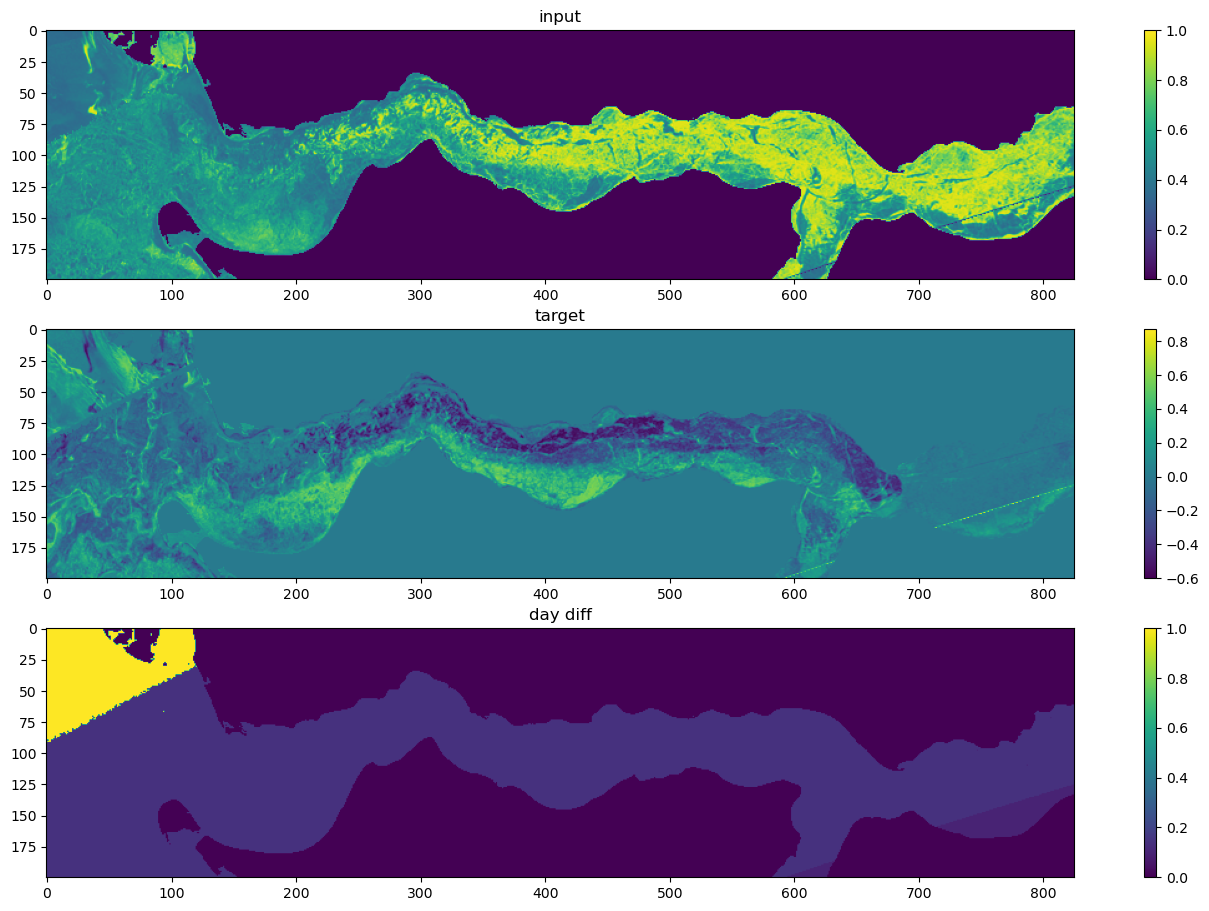

In [33]:
idx = 4
plt.figure(figsize=(18,11))
plt.subplot(3,1,1)
plt.imshow(input_data[idx,0].T)
plt.colorbar()
plt.title('input')
plt.subplot(3,1,2)
plt.imshow(target_difference[idx,0].T);
plt.colorbar()
plt.title('target')
plt.subplot(3,1,3)
plt.imshow(days_mask[idx,0].T)
plt.title('day diff')
plt.colorbar()
plt.show()

In [218]:
ds[idx]['target_idx']

20

In [219]:
ds[idx]['input_idxs']

[16, 14, 11]

In [335]:
def plot_map(x):
    plt.figure()
    plt.imshow(x.T)
    plt.show()

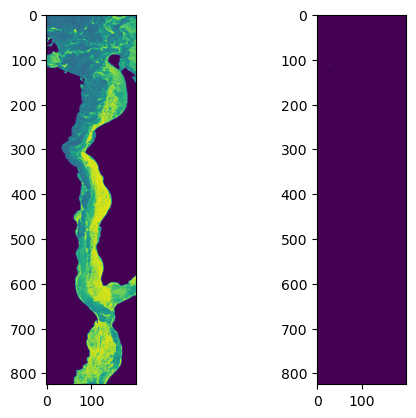

In [300]:
plt.subplot(1,2,1)
plt.imshow(output_image[0])
plt.subplot(1,2,2)
plt.imshow(output_image[1])




Text(0.5, 1.0, 'zeros 3.0')

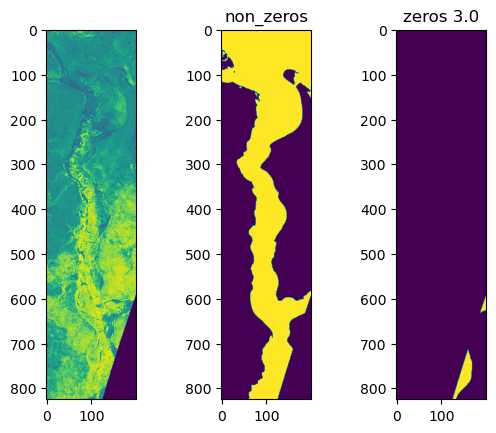

In [306]:
i = 14
plt.subplot(1,3,1)
plt.imshow(radar_data[i])
plt.subplot(1,3,2)
plt.imshow(other_in_mask[i])
plt.title('non_zeros')
plt.subplot(1,3,3)
plt.imshow(zeros_in_mask[i])
plt.title('zeros ' + str(np.round(zero_percentage[i])) )




In [81]:
A = torch.rand(5,5)>0.5
B = torch.rand(5,5)>0.5

In [84]:
A

tensor([[ True, False,  True,  True,  True],
        [ True, False, False, False, False],
        [False, False, False, False,  True],
        [ True, False,  True,  True,  True],
        [ True, False, False, False,  True]])

In [85]:
B

tensor([[ True, False,  True,  True,  True],
        [ True, False,  True,  True,  True],
        [ True,  True, False, False, False],
        [False,  True, False,  True,  True],
        [False, False, False,  True,  True]])

In [87]:
np.logical_and(A,B)

tensor([[1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1]], dtype=torch.uint8)

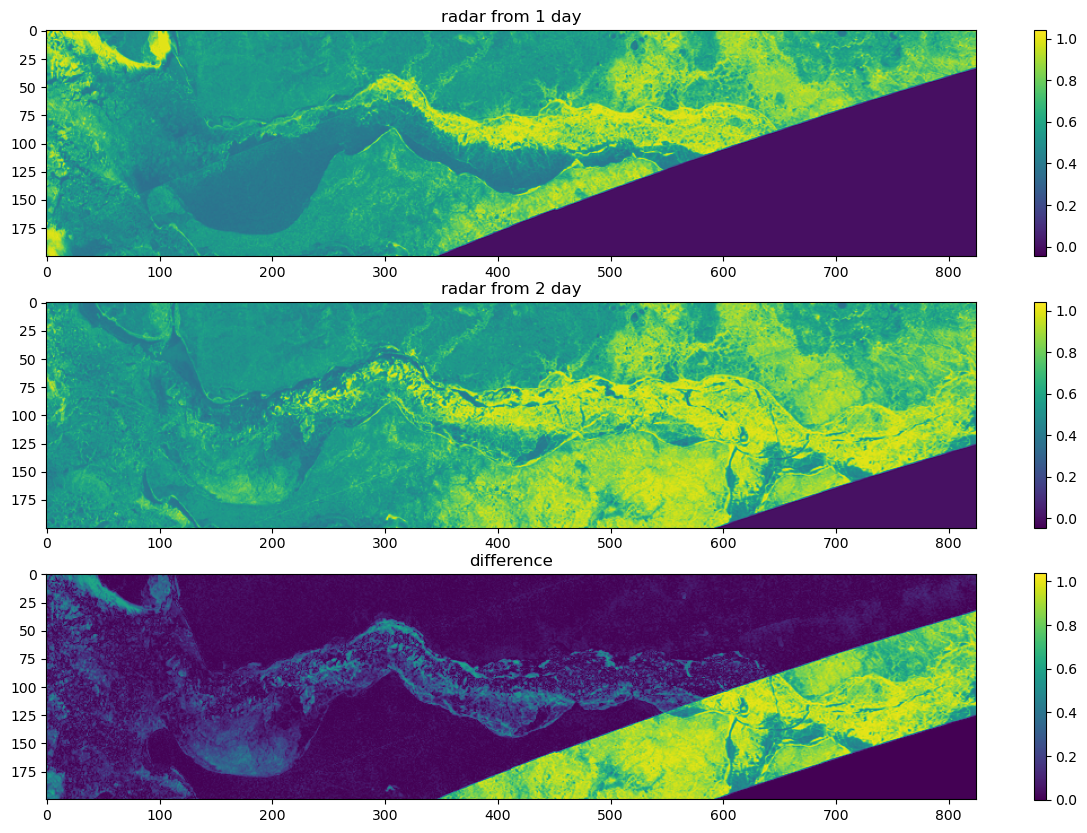

In [78]:
idx_s = 1
x1 = radar_data[6].T
y1 = radar_data[13].T
dif = x1 - y1

plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.imshow(x1)
plt.title('radar from {} day'.format(idx_s))

plt.colorbar()
plt.subplot(3,1,2)
plt.title('radar from {} day'.format(idx_s+1))
plt.imshow(y1)
plt.colorbar()

plt.subplot(3,1,3)
plt.title('difference')
plt.imshow(abs(x1-y1))
plt.colorbar()

In [3]:
batch_size = 5
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(radar_data[train_pairs[:, 0]]).unsqueeze(1), 
                                                                          torch.Tensor(radar_data[train_pairs[:, 1]]).unsqueeze(1)), 
                                                                          batch_size = batch_size, shuffle = False, 
                                                                          pin_memory = True)


valid_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(radar_data[valid_pairs[:, 0]]).unsqueeze(1), 
                                                                          torch.Tensor(radar_data[valid_pairs[:, 1]]).unsqueeze(1)), 
                                                                          batch_size = batch_size, shuffle = False, 
                                                                          pin_memory = True)


test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(radar_data[test_pairs[:, 0]]).unsqueeze(1), 
                                                                         torch.Tensor(radar_data[test_pairs[:, 1]]).unsqueeze(1)), 
                                                                         batch_size = batch_size, shuffle = False, 
                                                                         pin_memory = True)


In [46]:
x = next(iter(valid_loader))
x1, y1 = x[0], x[1]

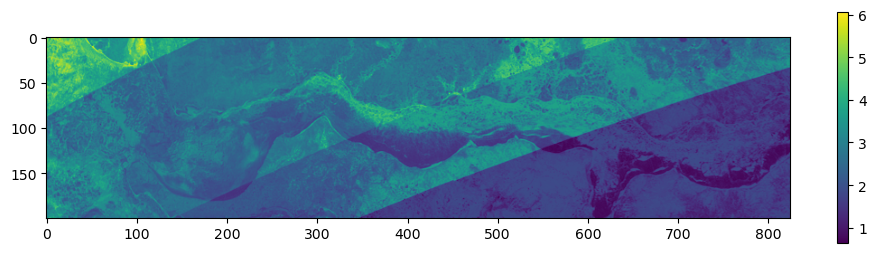

In [195]:
plt.figure(figsize=(12,3));
plt.imshow(radar_data[0:10].sum(0).T); plt.colorbar()

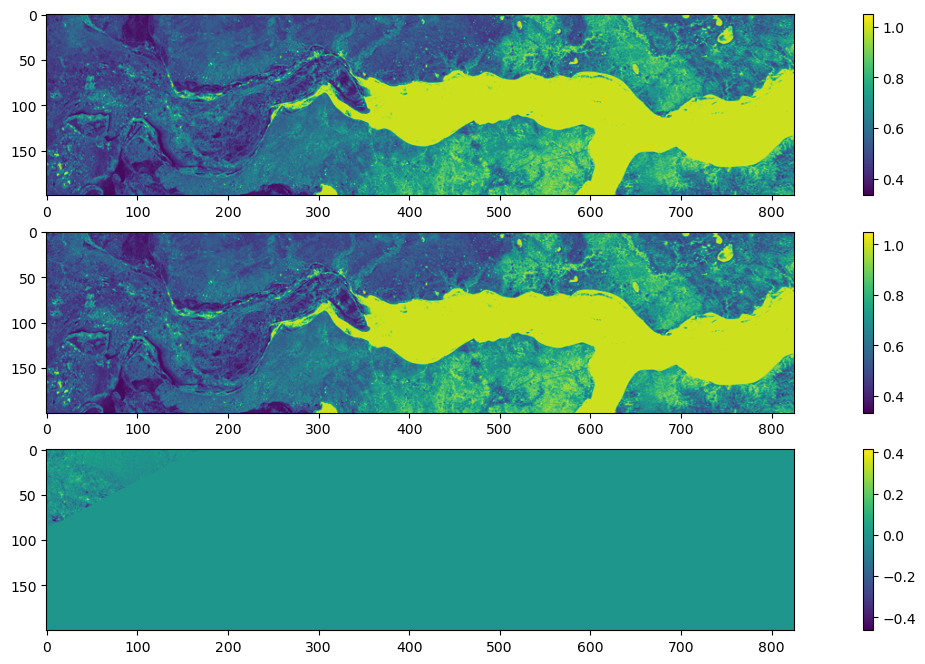

In [48]:
idx_sample = 0
plt.figure(figsize=(18,8))
plt.subplot(3,1,1)
plt.imshow(x1[idx_sample,0].T)
plt.colorbar()
plt.subplot(3,1,2)
plt.imshow(y1[idx_sample,0].T)
plt.colorbar()
plt.subplot(3,1,3)
plt.imshow(x1[idx_sample,0].T - y1[idx_sample,0].T)
plt.colorbar()



In [7]:
from radars.UNet import UNet

model = UNet(1, 1, False, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)


In [10]:
def train(device, model, optimizer, trainloader, epochs=20, evalloader=False, name_experiment='model_test'):
    train_loss_list = []
    valid_loss_list = []
    grad_list = []
    
    for ep in range(epochs):
        percent_epoch  = ep/epochs
        model.train()
        t_1 = default_timer()
        train_pred_full = 0
        total_grad = 0
        for x_train, y_train in trainloader:
            x_train = x_train.unsqueeze(1)
            y_train = y_train.unsqueeze(1)
            
            l_recons = 0
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            
            bs = x_train.shape[0]
            pred = model(x_train)
            loss = torch.nn.functional.mse_loss(pred.reshape(bs, -1),y_train.reshape(bs, -1) )

            train_pred_full += loss.item()

            optimizer.zero_grad()
            loss.backward()
            grad_by_batch  =  0
            for tag, value in model.named_parameters():
                if value.grad is not None:
                    grad =  value.grad.norm()
                    total_grad += grad 
                    grad_by_batch += grad

            optimizer.step()
            
        grad_list.append(total_grad.cpu().item())

        train_pred_full = train_pred_full / len(trainloader)

        train_loss_list.append(train_pred_full)

        t2 = default_timer()
        valid_pred_full = 0

        if evalloader:
            model.eval()
            with torch.no_grad():
                for x_valid, y_valid in evalloader:
                    x_valid = x_valid.unsqueeze(1)
                    y_valid = y_valid.unsqueeze(1)
                    
                    loss = 0
                    x_valid = x_valid.to(device)
                    y_valid = y_valid.to(device)
                    bs = x_valid.shape[0]
                    
                    pred = model(x_valid)

                    l_pred = torch.nn.functional.mse_loss(pred.reshape(bs, -1), y_valid.reshape(bs, -1))

                    valid_pred_full += l_pred.item()

            valid_pred_full = valid_pred_full / len(evalloader)

            valid_loss_list.append(valid_pred_full)

        #scheduler.step(loss)
        # scheduler.step()

        if evalloader:
            if ep == 0:
                print("Epoch", "Time", "[Train Pred MSE]", "[Eval Pred MSE], [total grad], [grad_by_batch]")
            if ep % 1 == 0:
                print(ep, t2 - t_1, train_pred_full, valid_pred_full, total_grad, grad_by_batch)


        #if ep % 99 == 0:
        #    torch.save(model.state_dict(), f"best_models_weights/{name_experiment}_{ep}.pth")
            
    return train_loss_list, valid_loss_list, grad_list

In [11]:
train_loss_list, valid_loss_list, grad_list = train(device, model, optimizer, 
                                         train_loader, epochs=1400, 
                                         evalloader=valid_loader)



: 

: 